# Detection & Classification of Undesirable Events in Offshore Oil Wells

# Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

pd.set_option('display.max_columns', None)

# Loading the Datasets

To download the datasets locally, check the README_Datasets.md file and follow the instructions.

In [ ]:
df_real = pd.read_csv('../Data/3W Original/real_instances.csv')
df_sim = pd.read_csv('../Data/3W Original/simulated_instances.csv')
df_drawn = pd.read_csv('../Data/3W Original/hand_drawn_instances.csv')

In [6]:
# combine the dataframes
df_combined = pd.concat([df_real, df_sim, df_drawn], axis=0)

In [7]:
df_combined.head()

,timestamp,label,well,id,ABER-CKGL,ABER-CKP,ESTADO-DHSV,ESTADO-M1,ESTADO-M2,ESTADO-PXO,ESTADO-SDV-GL,ESTADO-SDV-P,ESTADO-W1,ESTADO-W2,ESTADO-XO,P-ANULAR,P-JUS-BS,P-JUS-CKGL,P-JUS-CKP,P-MON-CKGL,P-MON-CKP,P-MON-SDV-P,P-PDG,PT-P,P-TPT,QBS,QGL,T-JUS-CKP,T-MON-CKP,T-PDG,T-TPT,class,state,Instance,DataType
0,2019-09-25 06:11:22,9,WELL-00035,20190925061122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16942270.0,NaN,NaN,1444127.0,NaN,NaN,NaN,0.0,NaN,1.582202,NaN,NaN,NaN,NaN,NaN,NaN,0,Real
1,2019-09-25 06:11:23,9,WELL-00035,20190925061122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16941320.0,NaN,NaN,1457562.0,NaN,NaN,NaN,0.0,NaN,1.582125,NaN,NaN,NaN,NaN,NaN,NaN,0,Real
2,2019-09-25 06:11:24,9,WELL-00035,20190925061122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16940370.0,NaN,NaN,1470998.0,NaN,NaN,NaN,0.0,NaN,1.582048,NaN,NaN,NaN,NaN,NaN,NaN,0,Real
3,2019-09-25 06:11:25,9,WELL-00035,20190925061122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16939430.0,NaN,NaN,1484433.0,NaN,NaN,NaN,0.0,NaN,1.581971,NaN,NaN,NaN,NaN,NaN,NaN,0,Real
4,2019-09-25 06:11:26,9,WELL-00035,20190925061122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16938480.0,NaN,NaN,1497868.0,NaN,NaN,NaN,0.0,NaN,1.581894,NaN,NaN,NaN,NaN,NaN,NaN,0,Real


# Data Overview

In [8]:
def data_overview(df):
    """
    Function to provide an overview of the dataset.

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.

    Returns:
    None: Prints the overview of the DataFrame.
    """
    num_rows = df.shape[0]
    num_columns = df.shape[1]
    num_categorical = df.select_dtypes(include=['object']).shape[1]
    num_numerical = df.select_dtypes(exclude=['object']).shape[1]
    num_instances = df["id"].nunique()

    # Print the overview
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_columns}")
    print(f"Number of categorical columns: {num_categorical}")
    print(f"Number of numerical columns: {num_numerical}")
    print(f"Number of unique instances: {num_instances}")

In [9]:
data_overview(df_real)

Number of rows: 32872250
Number of columns: 35
Number of categorical columns: 3
Number of numerical columns: 32
Number of unique instances: 1113


In [10]:
data_overview(df_sim)

Number of rows: 40748658
Number of columns: 35
Number of categorical columns: 3
Number of numerical columns: 32
Number of unique instances: 439


In [11]:
data_overview(df_drawn)

Number of rows: 2966410
Number of columns: 35
Number of categorical columns: 3
Number of numerical columns: 32
Number of unique instances: 10


# Dataset References

### Event Reference Table

In [12]:
label_descriptions = {
        0: 'NORMAL',
        1: 'ABRUPT INCREASE OF BSW',
        2: 'SPURIOUS CLOSURE OF DHSV',
        3: 'SEVERE SLUGGING',
        4: 'FLOW INSTABILITY',
        5: 'RAPID PRODUCTIVITY LOSS',
        6: 'QUICK RESTRICTION IN PCK',
        7: 'SCALING IN PCK',
        8: 'HYDRATE IN PRODUCTION LINE',
        9: 'HYDRATE IN SERVICE LINE'
    }

# Create a DataFrame from the dictionary
event_reference_table = pd.DataFrame(list(label_descriptions.items()), columns=['label', 'Description'])
event_reference_table

,label,Description
0,0,NORMAL
1,1,ABRUPT INCREASE OF BSW
2,2,SPURIOUS CLOSURE OF DHSV
3,3,SEVERE SLUGGING
4,4,FLOW INSTABILITY
5,5,RAPID PRODUCTIVITY LOSS
6,6,QUICK RESTRICTION IN PCK
7,7,SCALING IN PCK
8,8,HYDRATE IN PRODUCTION LINE
9,9,HYDRATE IN SERVICE LINE


### Feature Reference Table

In [13]:
# Dictionary of tags with their units
tags = {
    'ABER-CKGL': '%',
    'ABER-CKP': '%',
    'ESTADO-DHSV': '[0, 0.5, 1]',
    'ESTADO-M1': '[0, 0.5, 1]',
    'ESTADO-M2': '[0, 0.5, 1]',
    'ESTADO-PXO': '[0, 0.5, 1]',
    'ESTADO-SDV-GL': '[0, 0.5, 1]',
    'ESTADO-SDV-P': '[0, 0.5, 1]',
    'ESTADO-W1': '[0, 0.5, 1]',
    'ESTADO-W2': '[0, 0.5, 1]',
    'ESTADO-XO': '[0, 0.5, 1]',
    'P-ANULAR': 'Pa',
    'P-JUS-BS': 'Pa',
    'P-JUS-CKGL': 'Pa',
    'P-JUS-CKP': 'Pa',
    'P-MON-CKGL': 'Pa',
    'P-MON-CKP': 'Pa',
    'P-MON-SDV-P': 'Pa',
    'P-PDG': 'Pa',
    'PT-P': 'Pa',
    'P-TPT': 'Pa',
    'QBS': 'm3/s',
    'QGL': 'm3/s',
    'T-JUS-CKP': '°C',
    'T-MON-CKP': '°C',
    'T-PDG': '°C',
    'T-TPT': '°C',
    'class': 'Label',
    'state': 'Operational Status',
    'label': 'Instance Label',
    'well': 'Well Name',
    'id': 'Instance ID',
    'Instance': 'Instance ID (Manual)',
    'DataType': 'Dataset Type',
    'timestamp': 'Timestamp'
}

# Corresponding human-readable names for each tag
names = [
    'Opening of the GLCK (gas lift choke)',
    'Opening of the PCK (production choke)',
    'State of the DHSV (downhole safety valve)',
    'State of the PMV (production master valve)',
    'State of the AMV (annulus master valve)',
    'State of the PXO (pig-crossover) valve',
    'State of the gas lift SDV (shutdown valve)',
    'State of the production SDV (shutdown valve)',
    'State of the PWV (production wing valve)',
    'State of the AWV (annulus wing valve)',
    'State of the XO (crossover) valve',
    'Pressure in the well annulus',
    'Downstream pressure of the SP (service pump)',
    'Downstream pressure of the GLCK (gas lift choke)',
    'Downstream pressure of the PCK (production choke)',
    'Upstream pressure of the GLCK (gas lift choke)',
    'Upstream pressure of the PCK (production choke)',
    'Upstream pressure of the production SDV (shutdown valve)',
    'Pressure at the PDG (permanent downhole gauge)',
    'Downstream pressure of the PWV in the production tube',
    'Pressure at the TPT (temperature and pressure transducer)',
    'Flow rate at the SP (service pump)',
    'Gas lift flow rate',
    'Downstream temperature of the PCK (production choke)',
    'Upstream temperature of the PCK (production choke)',
    'Temperature at the PDG (permanent downhole gauge)',
    'Temperature at the TPT (temperature and pressure transducer)',
    'Label of the observation',
    'Well operational status',
    'Instance label (event type)',
    'Well name',
    'Instance identifier',
    'Instance count based on manual labeling',
    'Real , simulated or hand-drawn',
    'Timestamp'
]

# Creating a reference table
reference_table = pd.DataFrame(index=np.arange(1, len(names) + 1))
reference_table.index.name = 'Number'
reference_table['Tag'] = tags.keys()
reference_table['Name'] = names
reference_table['Unit'] = tags.values()

# Display the table
reference_table


,Tag,Name,Unit
Number,,,
1,ABER-CKGL,Opening of the GLCK (gas lift choke),%
2,ABER-CKP,Opening of the PCK (production choke),%
3,ESTADO-DHSV,State of the DHSV (downhole safety valve),"[0, 0.5, 1]"
4,ESTADO-M1,State of the PMV (production master valve),"[0, 0.5, 1]"
5,ESTADO-M2,State of the AMV (annulus master valve),"[0, 0.5, 1]"
6,ESTADO-PXO,State of the PXO (pig-crossover) valve,"[0, 0.5, 1]"
7,ESTADO-SDV-GL,State of the gas lift SDV (shutdown valve),"[0, 0.5, 1]"
8,ESTADO-SDV-P,State of the production SDV (shutdown valve),"[0, 0.5, 1]"
9,ESTADO-W1,State of the PWV (production wing valve),"[0, 0.5, 1]"


In [14]:
# check for columns in the combined dataframe but not in the reference table
missing_columns = set(df_combined.columns) - set(tags.keys())
missing_columns

set()

# Unique Values

In [15]:
def generate_unique_values_table(reference_table, df, column_name):
    # Step 1: Duplicate the reference_table
    unique_values_table = reference_table.copy()

    # Step 2: Add the specified column to store the number of unique values for each tag
    unique_values_table[column_name] = unique_values_table['Tag'].map(
        lambda tag: df[tag].nunique() if tag in df.columns else 0
    )

    return unique_values_table

In [16]:
unique_values_table = generate_unique_values_table(reference_table, df_real, 'Unique Values (Real)')
unique_values_table = generate_unique_values_table(unique_values_table, df_sim, 'Unique Values (Simulated)')
unique_values_table = generate_unique_values_table(unique_values_table, df_drawn, 'Unique Values (Hand-Drawn)')
unique_values_table = generate_unique_values_table(unique_values_table, df_combined, 'Unique Values (Combined)')

In [17]:
def add_value_type_column(unique_values_table):
    # Define the conditions for value type
    def determine_value_type(row):
        combined_value = row['Unique Values (Combined)']
        tag = row['Tag']
        
        # Condition 1: Check if unique values are 0
        if combined_value == 0:
            return "Empty"
        
        # Condition 2: Check if unique values are 3 or less
        if combined_value <= 3:
            return "Categorical"
        
        # Condition 3: Check if tag is 'label', 'class', or 'state'
        if tag in ['label', 'class', 'state']:
            return "Classifier"
        
        # Condition 4: Check if tag is 'well', 'id', or 'Instance'
        if tag in ['well', 'id', 'Instance']:
            return "Identifier"
        
        # Condition 5: Check if tag is 'DataType'
        if tag == 'DataType':
            return "Dataset"
        
        # Condition 6: Check if tag is 'timestamp'
        if tag == 'timestamp':
            return "Timestamp"
        
        # Default return for other types
        return "Continuous"

    # Apply the function to create the new 'Value Type' column
    unique_values_table['Value Type'] = unique_values_table.apply(determine_value_type, axis=1)
    
    # Reorder columns: place 'Value Type' after 'Unit'
    column_order = ['Tag', 'Name', 'Unit', 'Value Type', 'Unique Values (Real)', 'Unique Values (Simulated)', 
                    'Unique Values (Hand-Drawn)', 'Unique Values (Combined)']
    
    # Reordering the DataFrame columns
    unique_values_table = unique_values_table[column_order]

    return unique_values_table

In [18]:
unique_values_table = add_value_type_column(unique_values_table)
unique_values_table

,Tag,Name,Unit,Value Type,Unique Values (Real),Unique Values (Simulated),Unique Values (Hand-Drawn),Unique Values (Combined)
Number,,,,,,,,
1,ABER-CKGL,Opening of the GLCK (gas lift choke),%,Continuous,300484,0,0,300484
2,ABER-CKP,Opening of the PCK (production choke),%,Continuous,850210,0,0,850210
3,ESTADO-DHSV,State of the DHSV (downhole safety valve),"[0, 0.5, 1]",Categorical,2,0,0,2
4,ESTADO-M1,State of the PMV (production master valve),"[0, 0.5, 1]",Categorical,2,0,0,2
5,ESTADO-M2,State of the AMV (annulus master valve),"[0, 0.5, 1]",Categorical,3,0,0,3
6,ESTADO-PXO,State of the PXO (pig-crossover) valve,"[0, 0.5, 1]",Categorical,2,0,0,2
7,ESTADO-SDV-GL,State of the gas lift SDV (shutdown valve),"[0, 0.5, 1]",Categorical,2,0,0,2
8,ESTADO-SDV-P,State of the production SDV (shutdown valve),"[0, 0.5, 1]",Categorical,2,0,0,2
9,ESTADO-W1,State of the PWV (production wing valve),"[0, 0.5, 1]",Categorical,2,0,0,2


# Missing Values

In [19]:
def generate_missing_values_table(reference_table, df, column_name):
    # Step 1: Duplicate the reference_table
    missing_values_table = reference_table.copy()

    # Step 2: Add the specified column to store the percentage of missing values for each tag
    missing_values_table[column_name] = missing_values_table['Tag'].map(
        lambda tag: df[tag].isna().mean() * 100 if tag in df.columns else 100
    )

    return missing_values_table

In [20]:
unique_values_table_with_missing = generate_missing_values_table(unique_values_table, df_real, 'Missing Values (%) (Real)')
unique_values_table_with_missing = generate_missing_values_table(unique_values_table_with_missing, df_sim, 'Missing Values (%) (Simulated)')
unique_values_table_with_missing = generate_missing_values_table(unique_values_table_with_missing, df_drawn, 'Missing Values (%) (Hand-Drawn)')
unique_values_table_with_missing = generate_missing_values_table(unique_values_table_with_missing, df_combined, 'Missing Values (%) (Combined)')
unique_values_table_with_missing

,Tag,Name,Unit,Value Type,Unique Values (Real),Unique Values (Simulated),Unique Values (Hand-Drawn),Unique Values (Combined),Missing Values (%) (Real),Missing Values (%) (Simulated),Missing Values (%) (Hand-Drawn),Missing Values (%) (Combined)
Number,,,,,,,,,,,,
1,ABER-CKGL,Opening of the GLCK (gas lift choke),%,Continuous,300484,0,0,300484,74.168142,100.000000,100.0,88.912638
2,ABER-CKP,Opening of the PCK (production choke),%,Continuous,850210,0,0,850210,62.501934,100.000000,100.0,83.905354
3,ESTADO-DHSV,State of the DHSV (downhole safety valve),"[0, 0.5, 1]",Categorical,2,0,0,2,57.820359,100.000000,100.0,81.895962
4,ESTADO-M1,State of the PMV (production master valve),"[0, 0.5, 1]",Categorical,2,0,0,2,45.932496,100.000000,100.0,76.793540
5,ESTADO-M2,State of the AMV (annulus master valve),"[0, 0.5, 1]",Categorical,3,0,0,3,46.190839,100.000000,100.0,76.904424
6,ESTADO-PXO,State of the PXO (pig-crossover) valve,"[0, 0.5, 1]",Categorical,2,0,0,2,44.706544,100.000000,100.0,76.267346
7,ESTADO-SDV-GL,State of the gas lift SDV (shutdown valve),"[0, 0.5, 1]",Categorical,2,0,0,2,47.964405,100.000000,100.0,77.665661
8,ESTADO-SDV-P,State of the production SDV (shutdown valve),"[0, 0.5, 1]",Categorical,2,0,0,2,26.028468,100.000000,100.0,68.250478
9,ESTADO-W1,State of the PWV (production wing valve),"[0, 0.5, 1]",Categorical,2,0,0,2,42.388988,100.000000,100.0,75.272622


In [ ]:
# read the saved data for easy access 
#unique_values_table_with_missing = pd.read_csv('Results/dataset_reference_table_with_unique_and_missing.csv')

**Columns that are all null for real, simulated and hand drawn**
1. P-JUS-BS
2. P-MON-SDV-P
3. PT-P
4. QBS

*Will need to be removed during cleaning*

# Event Unique Instances

In [22]:
def count_unique_by_feature(df1, df2, df3, label_column, count_basis, df1_name='DF1', df2_name='DF2', df3_name='DF3'):
    # List of dataframes and their names
    dfs = [df1, df2, df3]
    names = [df1_name, df2_name, df3_name]

    # Ensure all values in the label_column are treated as strings
    df1[label_column] = df1[label_column].astype(str)
    df2[label_column] = df2[label_column].astype(str)
    df3[label_column] = df3[label_column].astype(str)

    # Get all unique labels across the three dataframes, ensuring they are strings
    all_labels = sorted(set(df1[label_column]).union(df2[label_column]).union(df3[label_column]))

    # Initialize a DataFrame to store the results
    result_df = pd.DataFrame(index=all_labels + ['Grand Total'], columns=[df1_name, df2_name, df3_name, 'Row Total'])

    # Iterate over the dataframes and calculate counts for each unique label based on the count_basis column
    for df, name in zip(dfs, names):
        # Group by the specified label column and count unique values of the specified count_basis column
        label_counts = df.groupby(label_column)[count_basis].nunique()

        # Create a new Series with the same index as all_labels, filling missing labels with 0
        counts_aligned = pd.Series(label_counts, index=all_labels).fillna(0)

        # Fill in the result dataframe
        result_df[name] = counts_aligned

    # Calculate the row totals
    result_df['Row Total'] = result_df[df1_name] + result_df[df2_name] + result_df[df3_name]

    # Calculate the column totals
    column_totals = result_df.sum(axis=0)

    # Add the column totals to the 'Grand Total' row
    result_df.loc['Grand Total'] = column_totals

    # Convert floats to integers for cleaner presentation
    result_df = result_df.astype(int)

    return result_df

In [23]:
count_unique_by_feature(df_real, df_sim, df_drawn, 'label', 'Instance', 'Real', 'Simulated', 'Hand-Drawn')

,Real,Simulated,Hand-Drawn,Row Total
0,594,0,0,594
1,4,114,10,128
2,22,16,0,38
3,32,74,0,106
4,343,0,0,343
5,11,439,0,450
6,6,215,0,221
7,36,0,10,46
8,14,81,0,95
9,57,150,0,207


In [24]:
count_unique_by_feature(df_real, df_sim, df_drawn, 'label', 'id', 'Real', 'Simulated', 'Hand-Drawn')

,Real,Simulated,Hand-Drawn,Row Total
0,588,0,0,588
1,4,114,10,128
2,22,16,0,38
3,32,74,0,106
4,343,0,0,343
5,11,439,0,450
6,6,215,0,221
7,36,0,10,46
8,14,81,0,95
9,57,150,0,207


In [55]:
def plot_histogram_three_datasets(df1, df2, df3, label_column, count_basis, df1_name='DF1', df2_name='DF2', df3_name='DF3'):
    # Ensure all values in the label_column are treated as strings
    df1[label_column] = df1[label_column].astype(str)
    df2[label_column] = df2[label_column].astype(str)
    df3[label_column] = df3[label_column].astype(str)

    # Get all unique labels across the three dataframes
    all_labels = sorted(set(df1[label_column]).union(df2[label_column]).union(df3[label_column]))

    # Initialize a DataFrame to store the counts
    result_df = pd.DataFrame(index=all_labels, columns=[df1_name, df2_name, df3_name])

    # Iterate over the dataframes and calculate counts for each unique label based on the count_basis column
    for df, name in zip([df1, df2, df3], [df1_name, df2_name, df3_name]):
        # Group by label_column and count unique values for count_basis
        label_counts = df.groupby(label_column)[count_basis].nunique()
        counts_aligned = pd.Series(label_counts, index=all_labels).fillna(0)
        result_df[name] = counts_aligned

    # Find the maximum y-value across all datasets for unified y-axis
    max_y = result_df.max().max()

    # Create subplots for the three datasets
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    # Plot the histogram for each dataset on its own subplot
    result_df[df1_name].plot(kind='bar', ax=axes[0], color='skyblue', width=0.8, legend=False)
    axes[0].set_title(f'{df1_name} - Unique {count_basis} Counts by {label_column}')
    axes[0].set_ylabel(f'Unique {count_basis} Counts')
    axes[0].set_ylim(0, max_y)  # Set the y-axis limit to be the same across all plots
    axes[0].set_xlabel(label_column)
    axes[0].set_xticks(range(len(all_labels)))
    axes[0].set_xticklabels(all_labels, rotation=45)

    result_df[df2_name].plot(kind='bar', ax=axes[1], color='lightgreen', width=0.8, legend=False)
    axes[1].set_title(f'{df2_name} - Unique {count_basis} Counts by {label_column}')
    axes[1].set_ylabel(f'Unique {count_basis} Counts')
    axes[1].set_ylim(0, max_y)  # Set the y-axis limit to be the same across all plots
    axes[1].set_xlabel(label_column)
    axes[1].set_xticks(range(len(all_labels)))
    axes[1].set_xticklabels(all_labels, rotation=45)

    result_df[df3_name].plot(kind='bar', ax=axes[2], color='salmon', width=0.8, legend=False)
    axes[2].set_title(f'{df3_name} - Unique {count_basis} Counts by {label_column}')
    axes[2].set_ylabel(f'Unique {count_basis} Counts')
    axes[2].set_ylim(0, max_y)  # Set the y-axis limit to be the same across all plots
    axes[2].set_xlabel(label_column)
    axes[2].set_xticks(range(len(all_labels)))
    axes[2].set_xticklabels(all_labels, rotation=45)

    # Adjust the layout to prevent overlap
    plt.tight_layout()
    plt.show()

def plot_histogram_single_dataset(df, label_column, count_basis, df_name='Dataset'):
    # Ensure all values in the label_column are treated as strings
    df[label_column] = df[label_column].astype(str)

    # Get all unique labels
    all_labels = sorted(df[label_column].unique())

    # Count unique values based on the count_basis column
    label_counts = df.groupby(label_column)[count_basis].nunique()

    # Create a new DataFrame
    result_df = pd.DataFrame({df_name: label_counts}, index=all_labels)

    # Plot histogram
    result_df.plot(kind='bar', figsize=(10, 6), width=0.8, legend=False)
    plt.title(f'Unique {count_basis} Counts by {label_column}')
    plt.ylabel(f'Unique {count_basis} Counts')
    plt.xlabel(label_column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

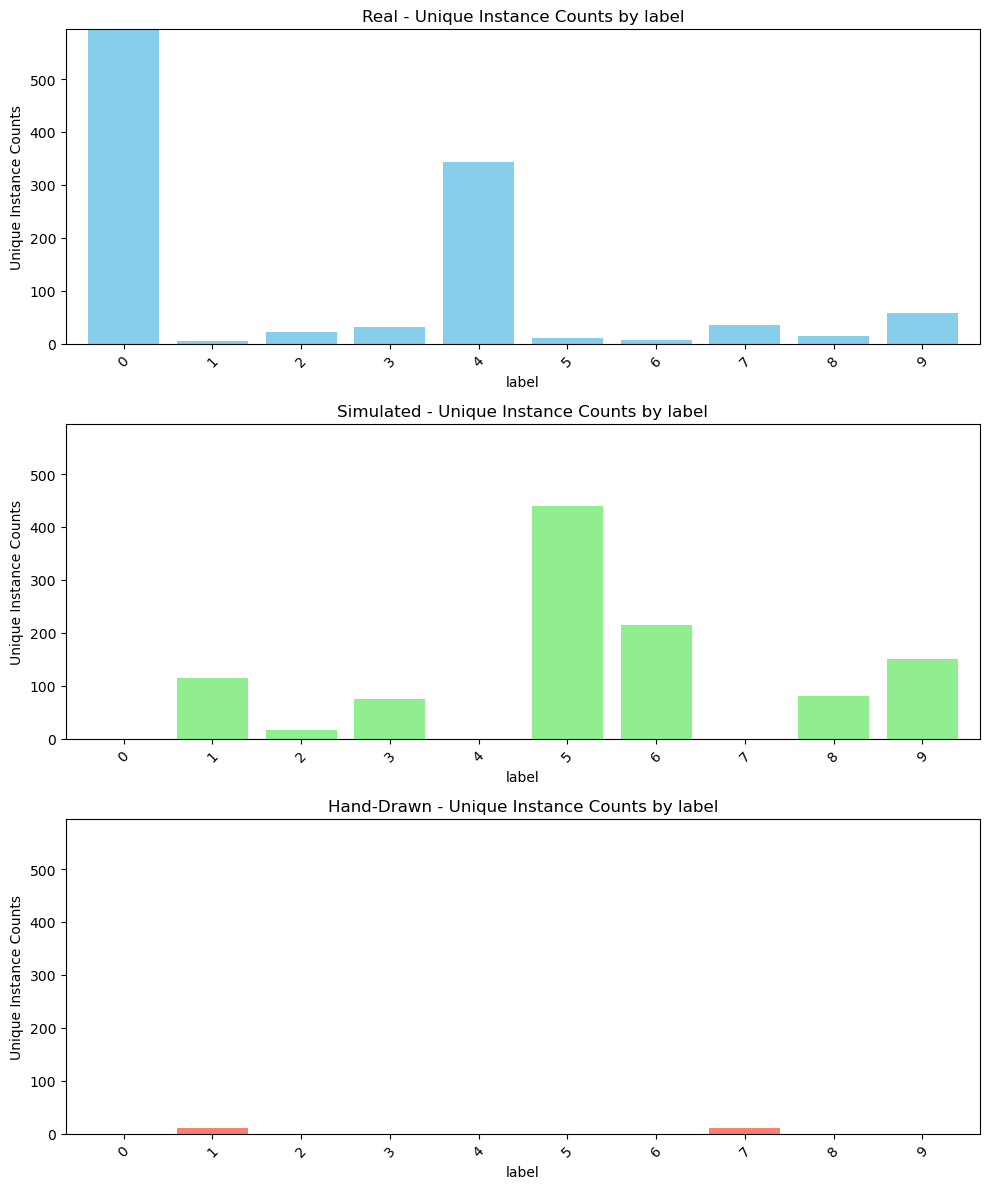

In [56]:
plot_histogram_three_datasets(df_real, df_sim, df_drawn, 'label', 'Instance', 'Real', 'Simulated', 'Hand-Drawn')

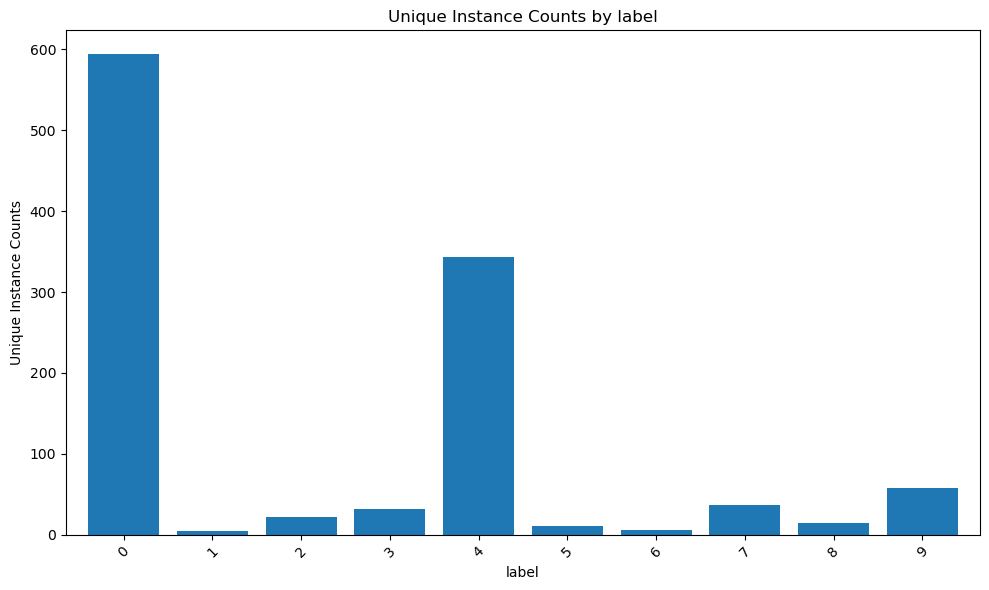

In [52]:
plot_histogram_single_dataset(df_real, 'label', 'Instance', 'Real')

# Compare different Identifiers

In [25]:
def compare_unique_values(df, label_column, identifier_1, identifier_2):
    # Get all unique labels in the dataframe
    all_labels = sorted(df[label_column].unique())

    # Initialize a DataFrame to store the results
    result_df = pd.DataFrame(index=all_labels + ['Grand Total'], columns=[identifier_1, identifier_2, 'Delta'])

    # Group by label and count unique values for identifier_1 and identifier_2
    identifier_1_counts = df.groupby(label_column)[identifier_1].nunique()
    identifier_2_counts = df.groupby(label_column)[identifier_2].nunique()

    # Create new Series with the same index as all_labels, filling missing labels with 0
    identifier_1_counts_aligned = pd.Series(identifier_1_counts, index=all_labels).fillna(0)
    identifier_2_counts_aligned = pd.Series(identifier_2_counts, index=all_labels).fillna(0)

    # Fill in the result dataframe with counts
    result_df[identifier_1] = identifier_1_counts_aligned
    result_df[identifier_2] = identifier_2_counts_aligned

    # Calculate the delta (difference between the two identifiers)
    result_df['Delta'] = result_df[identifier_1] - result_df[identifier_2]

    # Calculate the grand totals for each column
    grand_totals = result_df.sum(axis=0)
    
    # Add the grand totals to the 'Grand Total' row
    result_df.loc['Grand Total'] = grand_totals

    # Replace NaN values in the label column with 'Unknown' for non-numeric fields
    result_df.index = result_df.index.fillna('Unknown')

    # Replace NaN values in the numeric columns with 0
    result_df = result_df.fillna(0)

    # Convert numeric columns to integers for cleaner presentation
    result_df[[identifier_1, identifier_2, 'Delta']] = result_df[[identifier_1, identifier_2, 'Delta']].astype(int)

    return result_df

In [26]:
compare_unique_values(df_combined, 'label', 'Instance', 'id')

,Instance,id,Delta
0,594,588,6
1,128,118,10
2,38,38,0
3,106,106,0
4,343,343,0
5,450,450,0
6,221,221,0
7,46,46,0
8,95,95,0
9,207,207,0


In [27]:
compare_unique_values(df_combined, 'class', 'Instance', 'id')

,Instance,id,Delta
Unknown,0,0,0
0.0,1779,1177,602
1.0,124,118,6
2.0,27,27,0
3.0,106,106,0
4.0,343,343,0
5.0,446,446,0
6.0,221,221,0
7.0,9,9,0
8.0,73,73,0


In [28]:
compare_unique_values(df_combined, 'state', 'Instance', 'id')

,Instance,id,Delta
Unknown,0,0,0
0.0,2228,1552,676
1.0,12,12,0
2.0,6,6,0
3.0,3,3,0
4.0,4,4,0
5.0,2,2,0
6.0,3,3,0
7.0,6,6,0
8.0,9,9,0


In [29]:
def count_unique_values(df, row_feature, col_feature, count_feature):
    # Ensure all values in the row and column features are treated as strings and handle NaN values
    df[row_feature] = df[row_feature].fillna('Unknown').astype(str)
    df[col_feature] = df[col_feature].fillna('Unknown').astype(str)

    # Get all unique values from the row and column features
    unique_row_values = sorted(df[row_feature].unique())
    unique_col_values = sorted(df[col_feature].unique())

    # Initialize a DataFrame to store the results
    result_df = pd.DataFrame(index=unique_row_values + ['Grand Total'], columns=unique_col_values + ['Row Total'])

    # Group by the row and column features, then count unique values of the count feature
    for row_value in unique_row_values:
        for col_value in unique_col_values:
            # Filter the DataFrame for the specific row and column combination, then count unique 'count_feature'
            count = df[(df[row_feature] == row_value) & (df[col_feature] == col_value)][count_feature].nunique()
            result_df.loc[row_value, col_value] = count

    # Calculate row totals
    result_df['Row Total'] = result_df[unique_col_values].sum(axis=1)

    # Calculate column totals
    column_totals = result_df.sum(axis=0)
    
    # Add the column totals to the 'Grand Total' row
    result_df.loc['Grand Total'] = column_totals

    # Convert floats to integers for cleaner presentation
    result_df = result_df.fillna(0).astype(int)

    return result_df

In [30]:
count_unique_values(df_real, 'label', 'state', 'Instance')

/var/folders/lb/l6rxtm2x3b5crsslx9tskf940000gn/T/ipykernel_2227/1262013945.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df = result_df.fillna(0).astype(int)


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,Unknown,Row Total
0,594,1,0,1,1,1,1,1,1,594,1195
1,4,0,0,0,0,0,0,0,0,4,8
2,22,0,0,0,0,0,0,0,0,22,44
3,32,0,0,0,0,0,0,0,0,32,64
4,343,0,0,0,0,0,0,0,0,343,686
5,11,0,0,0,0,0,0,0,0,11,22
6,6,0,0,0,0,0,0,0,0,6,12
7,36,0,0,0,0,0,0,0,0,36,72
8,14,11,6,2,3,1,2,5,8,14,66
9,57,0,0,0,0,0,0,0,0,57,114


In [31]:
count_unique_values(df_real, 'label', 'class', 'Instance')

/var/folders/lb/l6rxtm2x3b5crsslx9tskf940000gn/T/ipykernel_2227/1262013945.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df = result_df.fillna(0).astype(int)


,0.0,1.0,101.0,102.0,105.0,106.0,107.0,108.0,109.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,Unknown,Row Total
0,594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,594,1188
1,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16
2,22,0,0,22,0,0,0,0,0,11,0,0,0,0,0,0,0,22,77
3,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,32,64
4,0,0,0,0,0,0,0,0,0,0,0,343,0,0,0,0,0,343,686
5,11,0,0,0,11,0,0,0,0,0,0,0,7,0,0,0,0,11,40
6,6,0,0,0,0,6,0,0,0,0,0,0,0,6,0,0,0,6,24
7,36,0,0,0,0,0,36,0,0,0,0,0,0,0,5,0,0,36,113
8,14,0,0,0,0,0,0,14,0,0,0,0,0,0,0,12,0,14,54
9,57,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,3,57,131


In [32]:
count_unique_values(df_real, 'state', 'class', 'Instance')

/var/folders/lb/l6rxtm2x3b5crsslx9tskf940000gn/T/ipykernel_2227/1262013945.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df = result_df.fillna(0).astype(int)


,0.0,1.0,101.0,102.0,105.0,106.0,107.0,108.0,109.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,Unknown,Row Total
0.0,744,4,4,22,11,6,36,8,14,11,32,343,7,6,5,1,3,0,1257
1.0,1,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,12
2.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5,0,0,6
3.0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,3
4.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,5
5.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
6.0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,3
7.0,1,0,0,0,0,0,0,4,0,0,0,0,0,0,0,3,0,0,8
8.0,1,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,9
Unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1119,1119


# Duplicates

In [33]:
# Count duplicate rows in each dataset
r_duplicates = df_real.duplicated().sum()
h_duplicates = df_drawn.duplicated().sum()
s_duplicates = df_sim.duplicated().sum()

# Create a DataFrame to display the counts
duplicate_counts = pd.DataFrame({
    'Dataset': ['Real', 'Hand-drawn', 'Simulated'],
    'Duplicate Rows': [r_duplicates, h_duplicates, s_duplicates]
})

print(duplicate_counts)

      Dataset  Duplicate Rows
0        Real               0
1  Hand-drawn               0
2   Simulated               0


In [34]:
# count the duplicate rows in the combined dataframe
combined_duplicates = df_combined.duplicated().sum()
print(f"Number of duplicate rows in the combined DataFrame: {combined_duplicates}")

Number of duplicate rows in the combined DataFrame: 0


In [48]:
# lets count the duplicated rows in each dataset excluding the id column
r_duplicates = df_real.drop('id', axis=1).duplicated().sum()
h_duplicates = df_drawn.drop('id', axis=1).duplicated().sum()
s_duplicates = df_sim.drop('id', axis=1).duplicated().sum()

# Create a DataFrame to display the counts
duplicate_counts = pd.DataFrame({
    'Dataset': ['Real', 'Hand-drawn', 'Simulated'],
    'Duplicate Rows (excluding ID)': [r_duplicates, h_duplicates, s_duplicates]
})

print(duplicate_counts)

      Dataset  Duplicate Rows (excluding ID)
0        Real                              0
1  Hand-drawn                              0
2   Simulated                              0


In [35]:
# display the duplicate rows in the combined dataframe
df_combined[df_combined.drop(df_combined.columns[3], axis=1).duplicated(keep=False)].sort_values('timestamp')

,timestamp,label,well,id,ABER-CKGL,ABER-CKP,ESTADO-DHSV,ESTADO-M1,ESTADO-M2,ESTADO-PXO,ESTADO-SDV-GL,ESTADO-SDV-P,ESTADO-W1,ESTADO-W2,ESTADO-XO,P-ANULAR,P-JUS-BS,P-JUS-CKGL,P-JUS-CKP,P-MON-CKGL,P-MON-CKP,P-MON-SDV-P,P-PDG,PT-P,P-TPT,QBS,QGL,T-JUS-CKP,T-MON-CKP,T-PDG,T-TPT,class,state,Instance,DataType
